In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../input/diabetic-retinopathy-224x224-2019-data/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()


,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

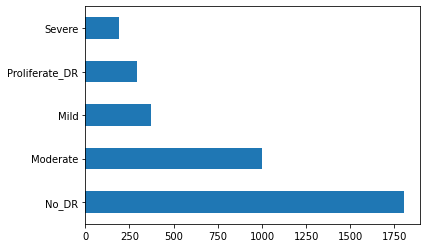

In [5]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

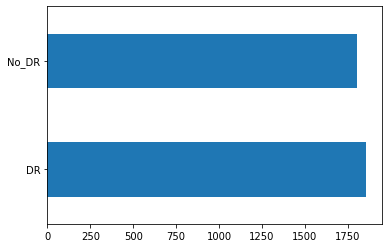

In [6]:
df['binary_type'].value_counts().plot(kind='barh')

In [7]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [8]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [ ]:
# Copy images to respective working directory
src_dir = r'../input/diabetic-retinopathy-224x224-2019-data/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [ ]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


In [ ]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

In [ ]:
model.save('64x3-CNN.model')
model.save("best_model.h5")

In [ ]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


18/18 [==============================] - 1s 71ms/step


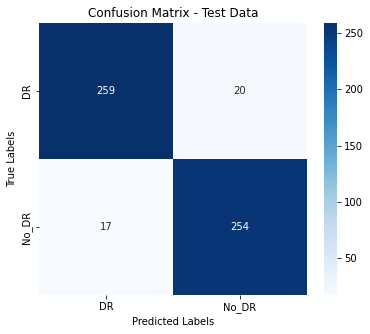

Classification Report:

              precision    recall  f1-score   support

          DR       0.94      0.93      0.93       279
       No_DR       0.93      0.94      0.93       271

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



<Figure size 432x288 with 0 Axes>

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Get true labels and predictions ---
test_batches.reset()
predictions = model.predict(test_batches, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys())

# --- Confusion Matrix ---
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()

# --- Classification Report ---
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
plt.savefig('/kaggle/working/confusion_matrix.png', bbox_inches='tight')

# ****Diabet Retinopathy Detection Section****

In [16]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

# Load trained model
#model = tf.keras.models.load_model("64x3-CNN.model")
model = tf.keras.models.load_model("best_model.h5")

# Class labels (binary)
class_names = ["DR", "No_DR"]

# Preprocessing function
def preprocess_image(image):
    # Resize to model's input size
    image = cv2.resize(image, (224, 224))
    image = image.astype("float32") / 255.0
    return np.expand_dims(image, axis=0)

# Prediction function
def predict(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Ensure correct channel order
    processed = preprocess_image(img)
    preds = model.predict(processed)[0]
    label = class_names[np.argmax(preds)]
    confidence = float(np.max(preds))
    return {class_names[0]: float(preds[0]),
            class_names[1]: float(preds[1])}, f"Prediction: {label} (Confidence: {confidence:.2f})"

# Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy", label="Upload Fundus Image"),
    outputs=[gr.Label(num_top_classes=2, label="Prediction Probabilities"),
             gr.Textbox(label="Final Result")],
    title="Diabetic Retinopathy Detection",
    description="Upload a retinal fundus image. Model predicts if DR is present."
)

if __name__ == "__main__":
    demo.launch()


IMPORTANT: You are using gradio version 3.34.0, however version 4.44.1 is available, please upgrade.
--------
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://d27ba1c9834e1b9236.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
